In [1]:
!pip install pydub

import get_note
import matplotlib.pyplot as plt
import numpy as np

You are using pip version 18.0, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
def get_nonzero_blocks(arr):
    zero_entries = (arr == 0)
    consecutive_zero_blocks = np.copy(zero_entries).astype(np.int)
    for i in range(consecutive_zero_blocks.shape[0]):
        if (i > 0) and (consecutive_zero_blocks[i-1] > 0) and (consecutive_zero_blocks[i] > 0):
            consecutive_zero_blocks[i] = consecutive_zero_blocks[i-1] + 1
    return consecutive_zero_blocks

def get_nonzero_block_bounds(arr, len_cutoff):
    nonzero_blocks = get_nonzero_blocks(arr)
    above_cutoff_locs = np.where(nonzero_blocks >= len_cutoff)[0]
    true_locations_followed_by_false = []
    for i, loc in enumerate(above_cutoff_locs):
        if (i + 1) == above_cutoff_locs.shape[0]:
            true_locations_followed_by_false.append((loc, nonzero_blocks[loc]))
        else:
            if above_cutoff_locs[i+1] != (loc + 1):
                true_locations_followed_by_false.append((loc, nonzero_blocks[loc]))
    return true_locations_followed_by_false


def partition_nonzero_blocks(arr, len_cutoff=1):
    true_locations_followed_by_false = get_nonzero_block_bounds(arr, len_cutoff)
    partition_inds = []
    for loc, run_len in true_locations_followed_by_false:
        start, end = loc - run_len + 1, loc
        partition_inds.append(start)
        partition_inds.append(end)
    all_runs = []

    if arr[0] != 0: # need to add the first block
        run_start = 0
        run_end = arr.shape[0] if len(partition_inds) == 0 else partition_inds[0]
        run = (run_start, run_end), arr[run_start:run_end]
        all_runs.append(run)

    for start_ind in range(1, len(partition_inds), 2):  # start at end of first zero block
        if len(partition_inds) <= (start_ind + 1):  # don't go out of bounds
            continue
        run_inds = (partition_inds[start_ind] + 1, partition_inds[start_ind + 1])
        run = run_inds, arr[run_inds[0]:run_inds[1]]
        all_runs.append(run)
    
    if arr[-1] != 0 and len(partition_inds) > 0:  # need to add the last block
        run_inds = (partition_inds[-1] + 1, arr.shape[0])
        run = run_inds, arr[run_inds[0]:run_inds[1]]
        all_runs.append(run)

    return all_runs

def index_into_arr(all_runs, arr):
    other_runs = []
    for run_tup, _ in all_runs:
        run_start, run_end = run_tup
        other_runs.append((run_tup, arr[run_start:run_end]))
    return other_runs

# shitty test infra ayy
def test_fn(name, fn, inp):
    print(name)
    print(inp)
    print(fn(inp))

test_fn("normal", partition_nonzero_blocks, np.array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]))

test_fn("doesn't start with 0", partition_nonzero_blocks, np.array([1, 1, 1, 0, 0, 0, 1, 0]))

test_fn("doesn't end with zero", partition_nonzero_blocks, np.array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1]))

test_fn("short gaps", partition_nonzero_blocks, np.array([0, 1, 0, 1, 0, 1, 0]))

test_fn("all zeros", partition_nonzero_blocks, np.array([0, 0, 0, 0, 0, 0]))

test_fn("no zeros", partition_nonzero_blocks, np.array([1, 1, 1, 1, 1, 1]))

print("test indexing")
tst_arr = np.array([0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0])
print(index_into_arr(partition_nonzero_blocks(tst_arr), tst_arr))

normal
[0 0 0 1 1 1 0 0 0 1 0]
[((3, 6), array([1, 1, 1])), ((9, 10), array([1]))]
doesn't start with 0
[1 1 1 0 0 0 1 0]
[((0, 3), array([1, 1, 1])), ((6, 7), array([1]))]
doesn't end with zero
[0 0 0 1 1 1 0 0 0 1]
[((3, 6), array([1, 1, 1])), ((9, 10), array([1]))]
short gaps
[0 1 0 1 0 1 0]
[((1, 2), array([1])), ((3, 4), array([1])), ((5, 6), array([1]))]
all zeros
[0 0 0 0 0 0]
[]
no zeros
[1 1 1 1 1 1]
[((0, 6), array([1, 1, 1, 1, 1, 1]))]
test indexing
[((3, 6), array([2, 2, 2])), ((9, 10), array([2]))]


In [3]:
frame_rate, mp3_arr = get_note.read(get_note.FILE)
mp3_arr.shape

(9965568,)
2


(4982784, 2)

In [4]:
magnitude_cutoff = 200
squish_below_cutoff = lambda arr: np.maximum(0, np.abs(arr) - magnitude_cutoff)

all_mp3_partitions = partition_nonzero_blocks(squish_below_cutoff(mp3_arr[:, 0]), len_cutoff=45)
orig_mp3_partitions = index_into_arr(all_mp3_partitions, mp3_arr[:, 0])

61


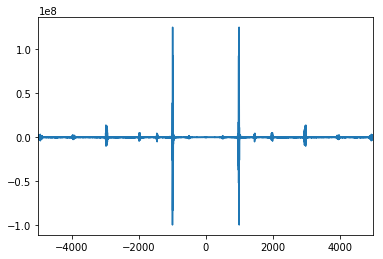

[ 996.77190912  992.43434641 -992.43434641]
(0, 992.43434641487158, ('B', 5))


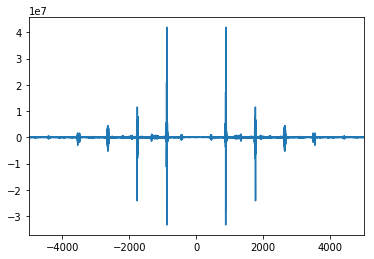

[ 876.29794154 -883.29433229  883.29433229]
(1, 883.29433228889866, ('A', 5))


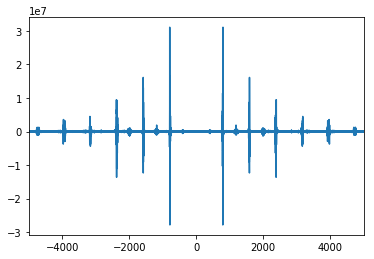

[ 789.99223742  795.25885233 -795.25885233]
(3, 795.25885233176098, ('G', 4))


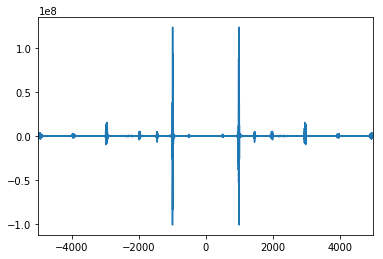

[ 996.77666621 -992.44285462  992.44285462]
(4, 992.44285461585332, ('B', 5))


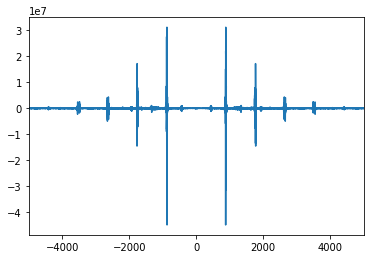

[ 880.38814509 -875.13209646  875.13209646]
(6, 875.1320964602121, ('A', 5))


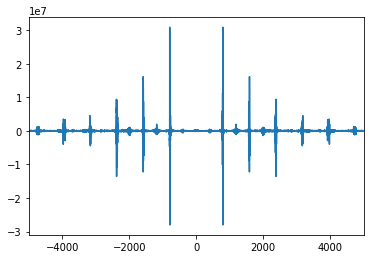

[ 789.99223742  795.25885233 -795.25885233]
(7, 795.25885233176098, ('G', 4))


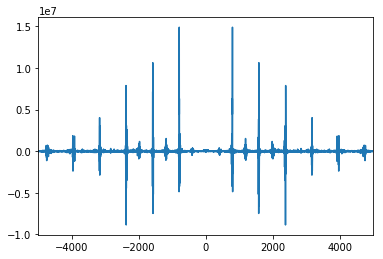

[-1583.99848765  -794.77818854   794.77818854]
(8, 794.77818853974122, ('G', 4))


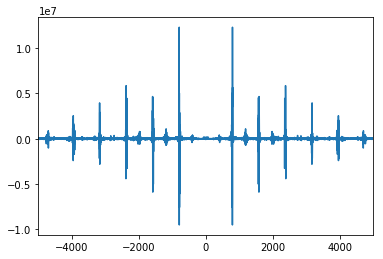

[ 793.39218159  795.24590164 -795.24590164]
(10, 795.24590163934431, ('G', 4))


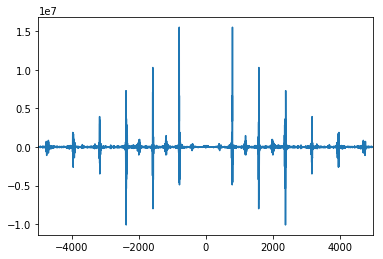

[-1583.99848765   794.77818854  -794.77818854]
(11, 794.77818853974122, ('G', 4))


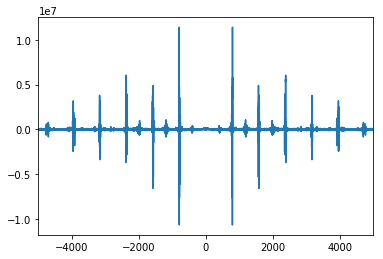

[ 793.42553281  795.27933078 -795.27933078]
(13, 795.27933078313504, ('G', 4))


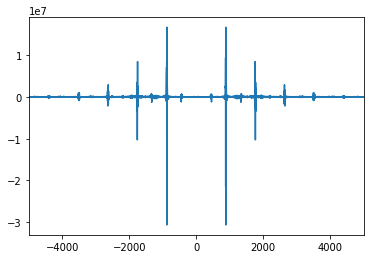

[-876.07361963 -883.43558282  883.43558282]
(15, 883.43558282208596, ('A', 5))


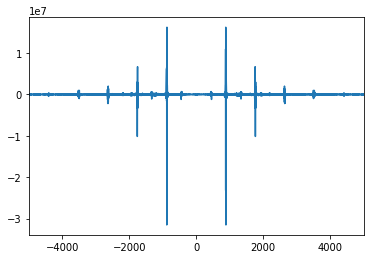

[-876.18332081  883.54620586 -883.54620586]
(17, 883.54620586025544, ('A', 5))


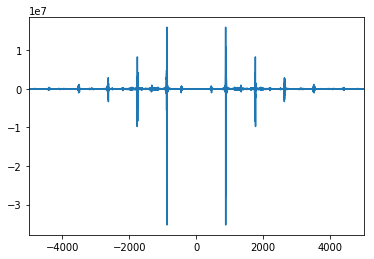

[ 883.90718563  876.57185629 -876.57185629]
(18, 876.57185628742525, ('A', 5))


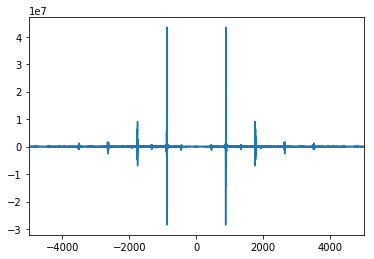

[ 875.43881645  879.12487462 -879.12487462]
(20, 879.12487462387151, ('A', 5))


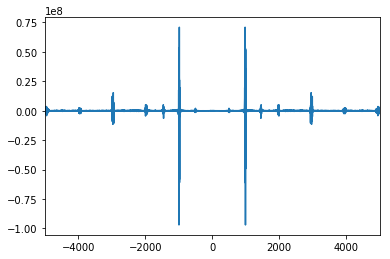

[-982.42788887 -992.83312688  992.83312688]
(21, 992.83312688019817, ('B', 5))


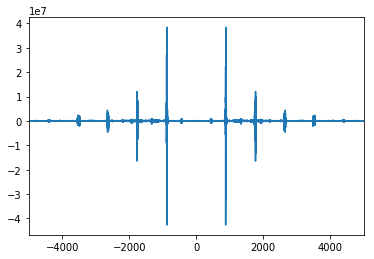

[ 878.72340426 -875.21902378  875.21902378]
(23, 875.21902377972469, ('A', 5))


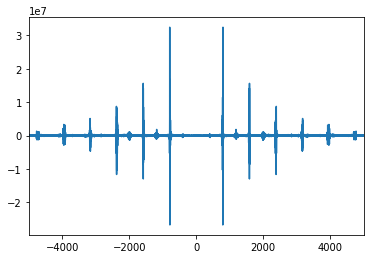

[-789.97651367  795.24302376 -795.24302376]
(25, 795.24302376497758, ('G', 4))


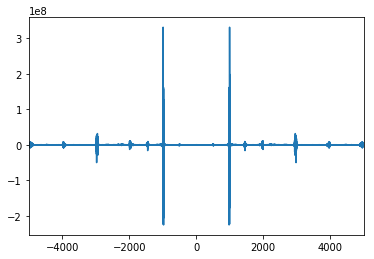

[ 978.74178475  992.42312153 -992.42312153]
(27, 992.4231215307442, ('B', 5))


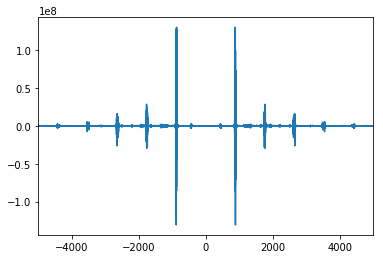

[ 874.38054875  883.66227231 -883.66227231]
(29, 883.66227230981178, ('A', 5))


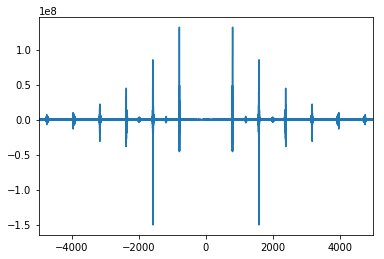

[ -795.24970248  1584.80851125 -1584.80851125]
(31, 1584.8085112484409, ('G', 5))


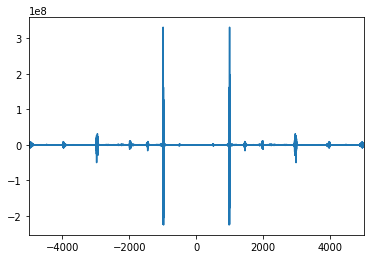

[ 978.74178475  992.42312153 -992.42312153]
(33, 992.4231215307442, ('B', 5))


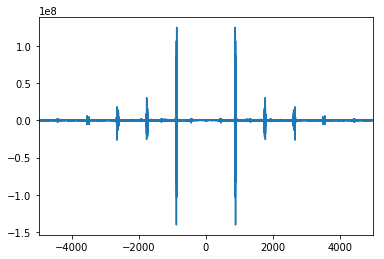

[-874.35963666 -883.43019501  883.43019501]
(35, 883.4301950148523, ('A', 5))


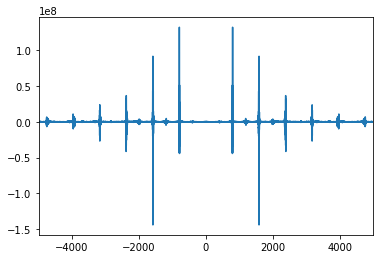

[ -795.24590164 -1584.80093677  1584.80093677]
(37, 1584.8009367681498, ('G', 5))


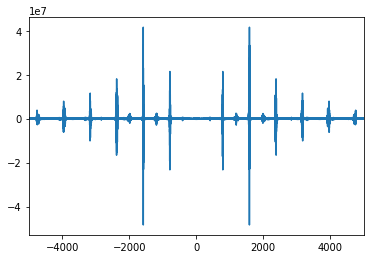

[ 1585.72176645  1584.86646884 -1584.86646884]
(39, 1584.86646884273, ('G', 5))


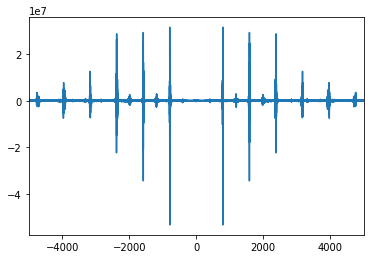

[ 1584.74352759   790.23368564  -790.23368564]
(41, 790.23368563948407, ('G', 4))


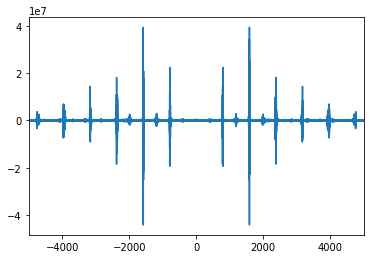

[ 1585.76205476  1585.33462564 -1585.33462564]
(42, 1585.3346256360551, ('G', 5))


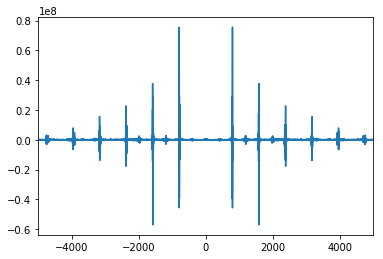

[ 1584.78697106   795.17231351  -795.17231351]
(44, 795.1723135087974, ('G', 4))


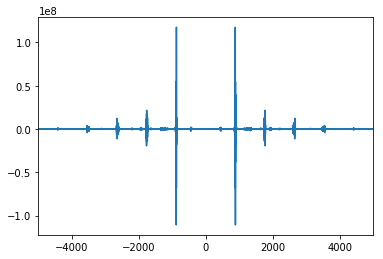

[-883.55670203 -878.85238271  878.85238271]
(46, 878.85238270718992, ('A', 5))


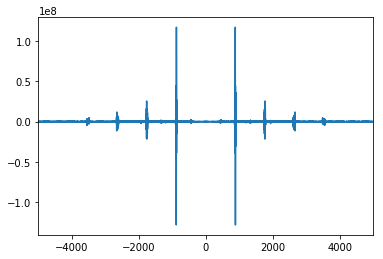

[ 878.90904855 -883.61825436  883.61825436]
(50, 883.61825436118477, ('A', 5))


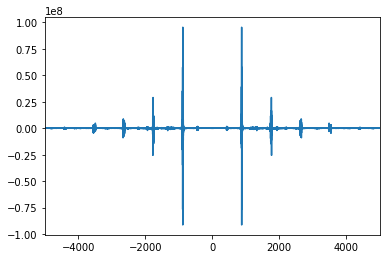

[ 879.66619174 -878.81131691  878.81131691]
(53, 878.81131691430903, ('A', 5))


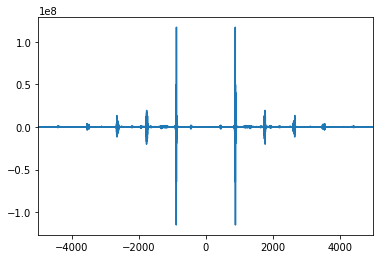

[-883.54663386 -878.84691772  878.84691772]
(55, 878.84691771863697, ('A', 5))


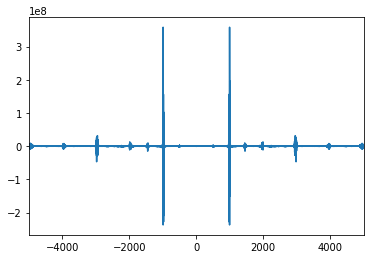

[-992.21686299  992.42725672 -992.42725672]
(56, 992.42725672329652, ('B', 5))


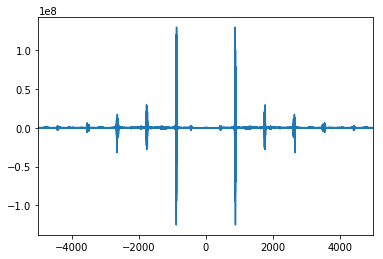

[ 883.45132405  874.38054875 -874.38054875]
(58, 874.38054875248747, ('A', 5))


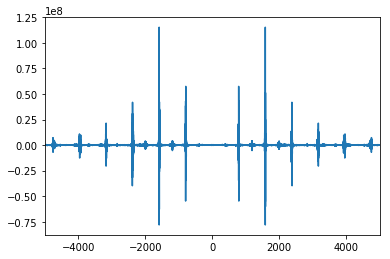

[ 1584.88293739 -1585.30444881  1585.30444881]
(60, 1585.3044488093019, ('G', 5))


In [5]:
def get_hz(partition):
    partition_inds, partition_vals = partition
    ind_range = np.arange(partition_inds[0], partition_inds[1])
    
    spec = np.fft.fft(partition_vals)
    freq = np.fft.fftfreq(ind_range.shape[-1])
    
    plt.plot(44100*freq, spec.real)
    plt.xlim(-5000, 5000)
    #plt.plot(freq, spec.imag)
    plt.show()
    
    top_5 = np.argpartition(np.abs(spec.real), -3)[-3:]
    #big_cutoff = np.percentile(np.abs(spec.real), 99.99)

    #big_vals = np.where(np.abs(spec.real) > big_cutoff)

    print(44100*freq[top_5])
    
    hz = np.median(44100 * np.abs(freq[top_5]))
    
    return hz

def hz_to_note(hz):
    # assumes A4 = 440 Hz
    all_note_names = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']

    note_diff = int(round(12*np.log2(hz / 440)))
    
    octave = 4 + note_diff // 12
    note_ind = note_diff % 12
    note_name = all_note_names[note_ind]
    return note_name, octave

print(len(orig_mp3_partitions))
for i, partition in enumerate(orig_mp3_partitions):
    partition_inds, partition_vals = partition
    if partition_inds[1] - partition_inds[0] <= 150:  # arbitrary but fairly robust cutoff
        continue

    hz = get_hz(partition)
    note = hz_to_note(hz)
    print(i, hz, note)

In [ ]:
fake_x = np.arange(1000)
fake_arr = np.sin(fake_x)
fake_spec = np.fft.fft(fake_arr)
fake_freq = np.fft.fftfreq(fake_x.shape[-1])

plt.plot(fake_freq, fake_spec.real, fake_freq, fake_spec.imag)
plt.show()

In [ ]:
# start, end =  354000, 405000
# start, end = 407000, 458000
# start, end = 459600, 511000
start, end = 404600, 407500
trunc_arr = mp3_arr[start:end, 0]
trunc_x = np.arange(start, end)
plt.plot(trunc_x, trunc_arr)
plt.show()

In [ ]:
trunc_spec = np.fft.fft(trunc_arr)
trunc_freq = np.fft.fftfreq(trunc_x.shape[-1])
plt.plot(trunc_freq, trunc_spec.real)
plt.plot(trunc_freq, trunc_spec.imag)
plt.show()

largest_freqs = np.argpartition(np.abs(trunc_spec.real), -20)[-20:]
for freq in largest_freqs:
    print(trunc_freq[freq]*44100, trunc_spec.real[freq], trunc_spec.imag[freq])

In [ ]:
for i, (partition_inds, partition_vals) in enumerate(orig_mp3_partitions):
    if partition_inds[1] - partition_inds[0] <= 150:  # arbitrary but fairly robust cutoff
        continue
    ind_range = np.arange(partition_inds[0], partition_inds[1])
    plt.plot(ind_range, partition_vals)
    plt.show()
    #fname = 'mp3_{}'.format(i)
    #get_note.write(fname, frame_rate, partition_vals)